# **XPM 1D Inverse Design**
We assume equations of form:
$$
\frac{\partial A_1}{\partial z} 
= - i\frac{\beta_{21}}{2} \frac{\partial^2 A_1}{\partial T^2} + i\gamma_1 \bigl[ |A_1|^2 + 2|A_2|^2 \bigr]A_1 = \bigl[ \mathscr{L_1} + \mathscr{N}_1  \bigr] A_1
$$
$$
\frac{\partial A_2}{\partial z}  
= -
i\frac{\beta_{22}}{2} \frac{\partial^2 A_2}{\partial T^2} + i\gamma_2 \bigl[ |A_2|^2 + 2|A_1|^2 \bigr]A_2 =  \bigl[ \mathscr{L_2} + \mathscr{N}_2  \bigr] A_2
$$


In [59]:
# general imports
import numpy as np
import matplotlib.pyplot as plt

# ml imports
import torch
import torch.nn.functional as F
from tqdm import tqdm

# import module
from nlse import *

## **Useful Functions**

In [40]:
def gaussian_pulse(t, center=0.0, T0=0.5, A0=0.01): # A0 = P0**2
    """Generate a Gaussian pulse using PyTorch."""
    return A0 * torch.exp(-((t - center) ** 2) / (2 * T0 ** 2))

def sech_pulse(t, center=0.0, T0=1.0, A0=1.0):
    """Generate a Gaussian pulse."""
    return A0* 1/torch.cosh( (t-center)/ T0 + 1e-16) + 1e-16

def square_pulse(t, center=0.0, w=1.0, A0=1.0):
    """Generate a square pulse using PyTorch."""
    return A0 * ((t >= center - w/2) & (t <= center + w/2))


## **Testing**

### Parameters

In [41]:
# define simulation parameters
Lz = 4e-2               # Propagation distance in km (1cm = 1e-5)
Nz = 4000               # Number of steps in z
dz = Lz / Nz            # Step size in z
Lt = 10                  # Temporal window size
Nt = 1024               # Number of temporal points
dt = Lt / Nt

# define medium parameters
beta2_j = -20           # anomalous GVD region
beta2_k = -20           # anomalous GVD region
gamma_j = 20
gamma_k = 20

### Simulation

In [42]:
# independent variable (we use torch for automatic differentiation)
t = torch.linspace(-Lt/2, Lt/2, Nt) 

Ain_j = gaussian_pulse(t)
Ain_k = torch.nn.Parameter(sech_pulse(t).clone().detach().requires_grad_(True))

# Perform the split-step Fourier method
A_j_evolution, A_k_evolution  = split_step_fourier_xpm(Ain_j, Ain_k, dz, Nz, beta2_j, beta2_k, gamma_j, gamma_k, Lt)

### Plotting

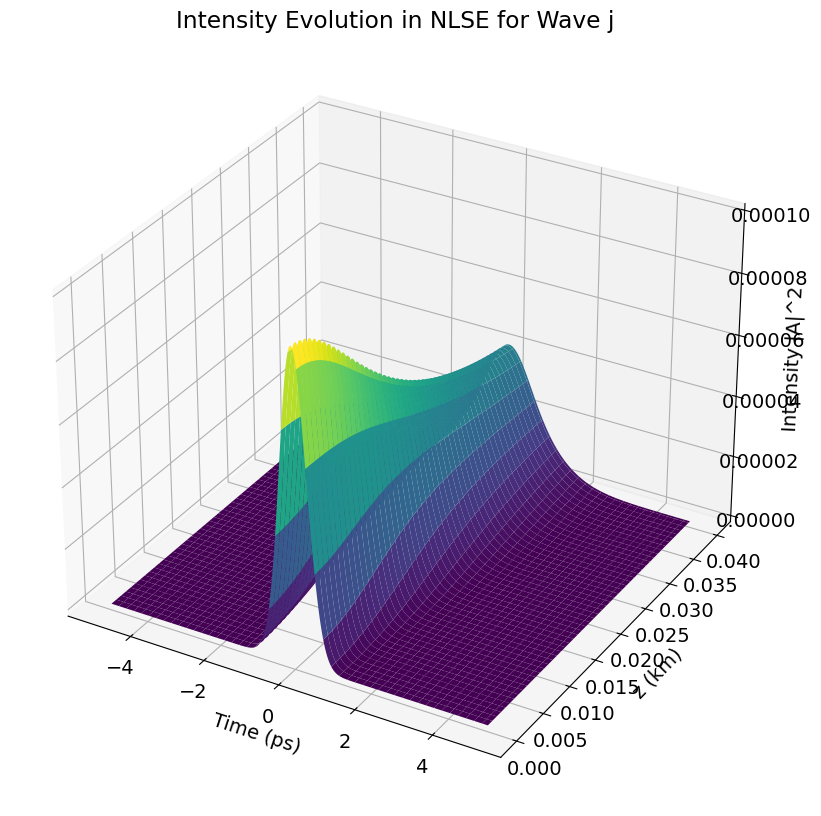

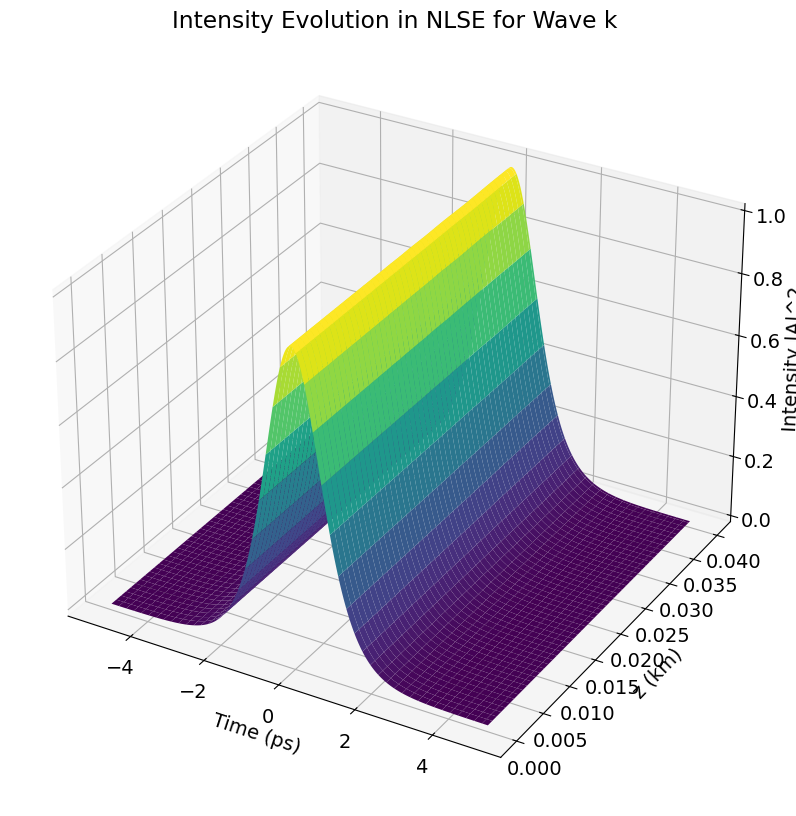

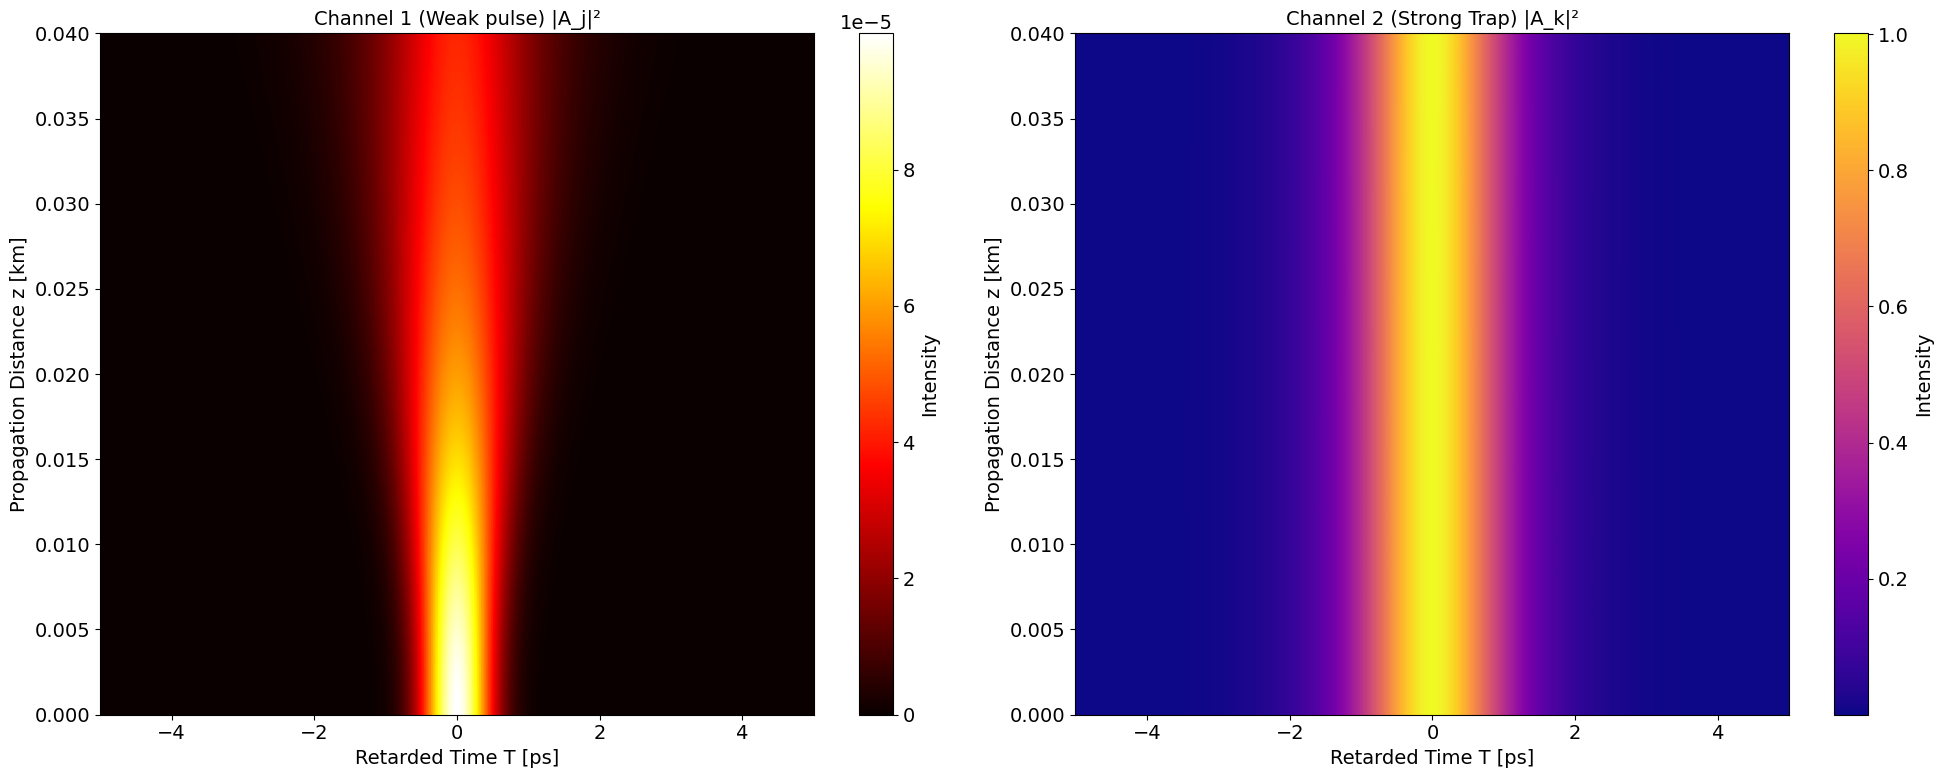

In [43]:
plot_intensity_evolution(A_j_evolution, t, Lz, Nz, wave_name='Wave j')
plot_intensity_evolution(A_k_evolution, t, Lz, Nz, wave_name='Wave k')
plot_cowave_evolution(A_j_evolution.detach().clone(), A_k_evolution.detach().clone(), t, Lz, Nz)

### Evaluation

In [44]:
# Energy should be conserved (no loss)
print(f"Initial energy of wave j: {get_energy(A_j_evolution[:,0], dt):.8f} wave k: {get_energy(A_k_evolution[:,0], dt):.4f}")
print(f"Final energy of wave j: {get_energy(A_j_evolution[:,-1], dt):.8f} wave k: {get_energy(A_k_evolution[:,-1], dt):.4f}")

Initial energy of wave j: 0.00008854 wave k: 1.9979
Final energy of wave j: 0.00008858 wave k: 1.9984


## **Inverse Design 1: Square Wave**

### Parameters

In [ ]:
# define simulation parameters
Lz = 1e-2               # Propagation distance in km (1cm = 1e-5)
Nz = 1000               # Number of steps in z
dz = Lz / Nz            # Step size in z
Lt = 12                  # Temporal window size
Nt = 1024               # Number of temporal points
dt = Lt / Nt

# define medium parameters
beta2_j = -20           # anomalous GVD region
beta2_k = -30           # anomalous GVD region
gamma_j = 20
gamma_k = 20

# define target parameters
w = 3 # width of square wave target (ps)

# define simulation parameters
mask_percent = 0.8 # size of the unpenalized region in percent of the total temporal window
m = 8 # number of slices to check for penalty
w_mse = 1e10
w_pen = 1e5 # penalty weight
lr = 1e-1
N_train = 10

### Initialization
We have to initialize the inout waveforms and also **define the target**. Note that since energy is conserved the square wave must have the same energy as the weak input wave.

We set the (temporal) width of the target arbitrarily as $w = 3 \, ps$. Defining it's amplitude as $A_s$ it's total energy would be $E = A_s^2 \cdot w$ and thus
$$A_s = \sqrt{\frac{E}{w}} $$

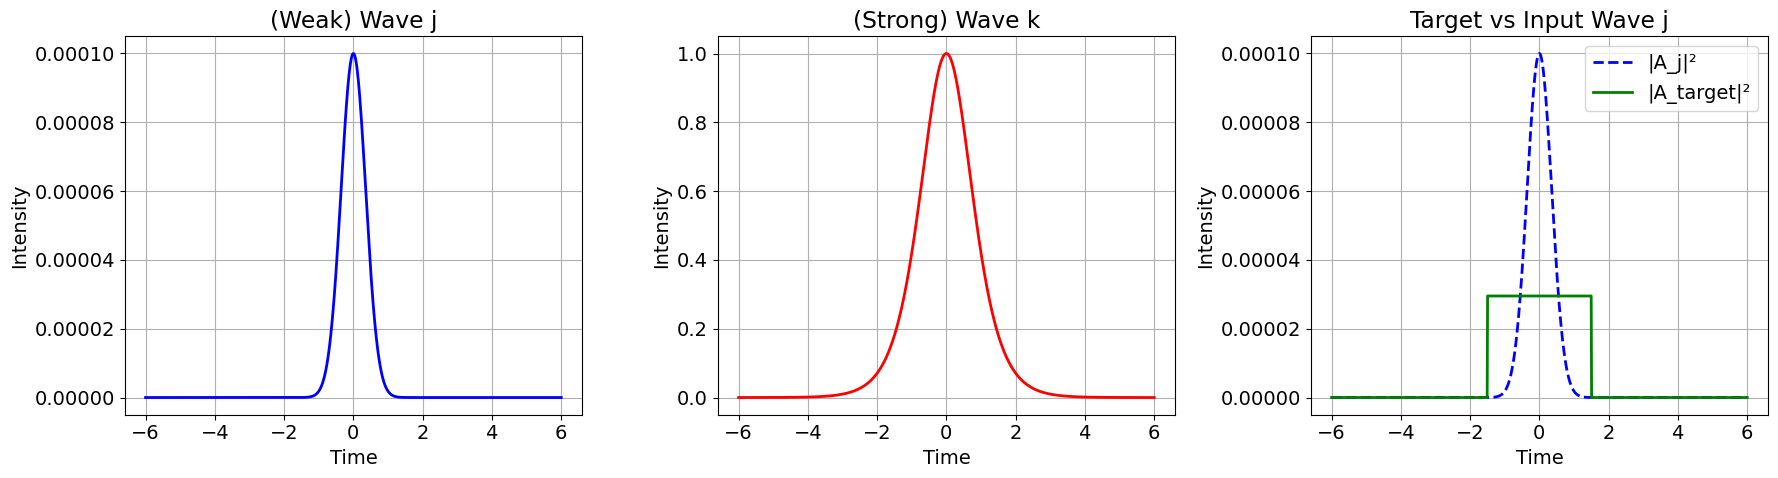

Energy of target: 88.53614044e-6
Energy of input j: 88.53614044e-6


In [ ]:
""" define inputs """
# define inputs
t = torch.linspace(-Lt/2, Lt/2, Nt) 
Ain_j = gaussian_pulse(t)
Ain_k = torch.nn.Parameter(sech_pulse(t).clone().detach().requires_grad_(True)) # our controllable parameters

# define target
Ein = get_energy(Ain_j, dt)
A_s = np.sqrt(Ein/w)
A_target = square_pulse(t, center=0.0, w=w, A0=A_s)

# plot input waveforms
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
ax1.plot(t.detach().numpy(), np.abs(Ain_j.detach().numpy())**2, 'b-', linewidth=2, label='|A_j|²')
ax1.set_xlabel('Time')
ax1.set_ylabel('Intensity')
ax1.set_title('(Weak) Wave j')
ax1.grid(True)
ax2.plot(t.detach().numpy(), np.abs(Ain_k.detach().numpy())**2, 'r-', linewidth=2, label='|A_k|²')
ax2.set_xlabel('Time')
ax2.set_ylabel('Intensity')
ax2.set_title('(Strong) Wave k')
ax2.grid(True)
ax3.plot(t.detach().numpy(), np.abs(Ain_j.detach().numpy())**2, 'b--', linewidth=2, label='|A_j|²')
ax3.plot(t.detach().numpy(), np.abs(A_target.detach().numpy())**2, 'g-', linewidth=2, label='|A_target|²')
ax3.set_xlabel('Time')
ax3.set_ylabel('Intensity')
ax3.set_title('Target vs Input Wave j')
ax3.legend()
ax3.grid(True)
plt.tight_layout()
plt.show()

# check energy conservation
print(f"Energy of target: {get_energy(A_target, dt)* 1e6:.8f}e-6")
print(f"Energy of input j: {get_energy(Ain_j, dt)* 1e6:.8f}e-6")


""" define training functions and objects """
# define penalty mask (takes values of 1 where the wave is not allowed to have nonzero values)
penalty = torch.zeros_like(t)
penalty[:int(Nt/2-Nt*mask_percent/2)] = 1
penalty[int(Nt/2+Nt*mask_percent/2):] = 1
iters = np.linspace(0, Nz-1, m).astype(int)

# define loss function
def loss_function(A_j_evolution, A_k_evolution):
    
    # mse loss 
    mse_loss = F.mse_loss(torch.abs(A_j_evolution[:, -1])**2, torch.abs(A_target)**2)

    # # penalization loss - to enforce none of the waves to stray outside the simulation bounds
    # pen_loss = 0    
    # for i in iters:
    #     pen_loss += F.mse_loss(torch.abs(A_j_evolution[:, i]*penalty)**2, torch.zeros(Nt))   
    #     pen_loss += F.mse_loss(torch.abs(A_k_evolution[:, i]*penalty)**2, torch.zeros(Nt))   
   
    return w_mse * mse_loss

# define forward pass
def forward(Ain_strong): # in-> Ain_k, out-> A_evolution[:, -1]
    return split_step_fourier_xpm(Ain_j, Ain_strong, dz, Nz, beta2_j, beta2_k, gamma_j, gamma_k, Lt)

# initialize optimizer
optimizer = torch.optim.Adam([Ain_k], lr=lr)


### Training

In [69]:
losses = []
for i in tqdm(range(N_train), desc="Training"):
    optimizer.zero_grad()
    A_j_evolution, A_k_evolution = forward(Ain_k)
    loss = loss_function(A_j_evolution, A_k_evolution)
    loss.backward()
    optimizer.step()

    # save and print the loss every 10 iteration
    if i % 10 == 0:
        losses.append(loss.item())

Training: 100%|██████████| 10/10 [00:44<00:00,  4.41s/it]


### Evaluation

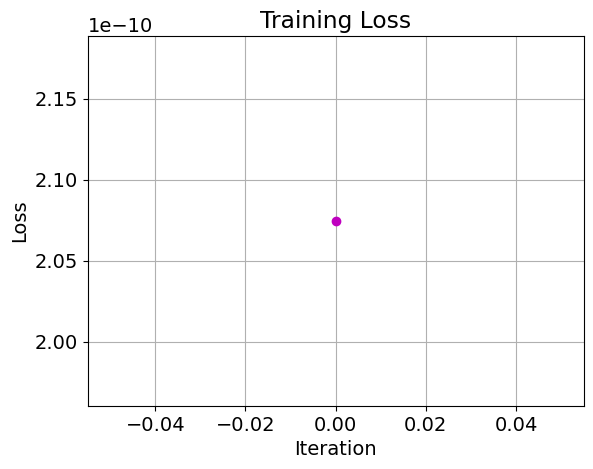

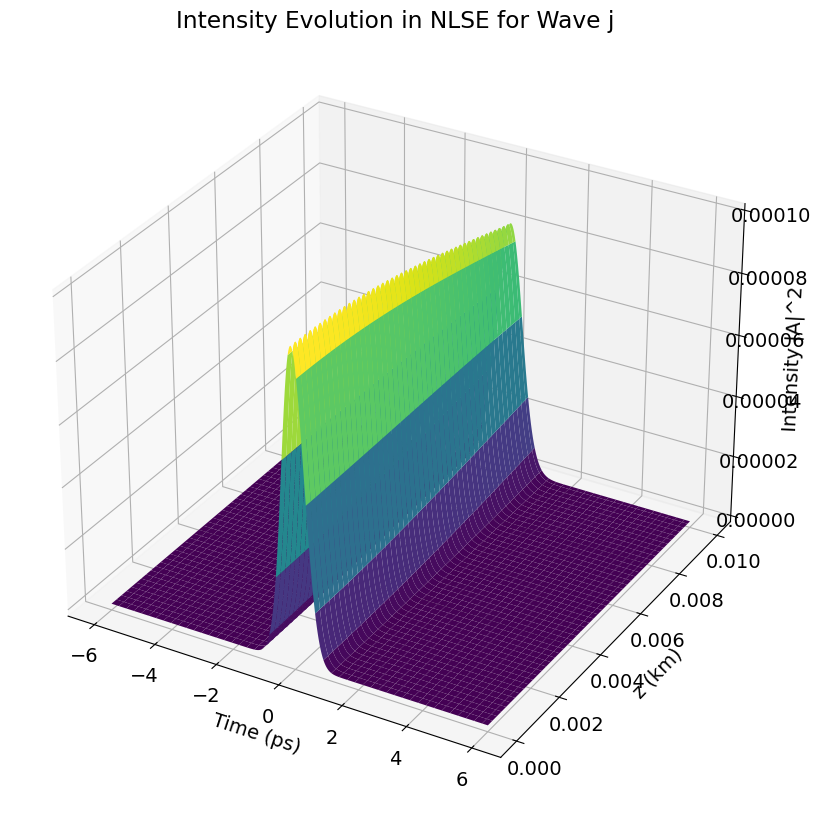

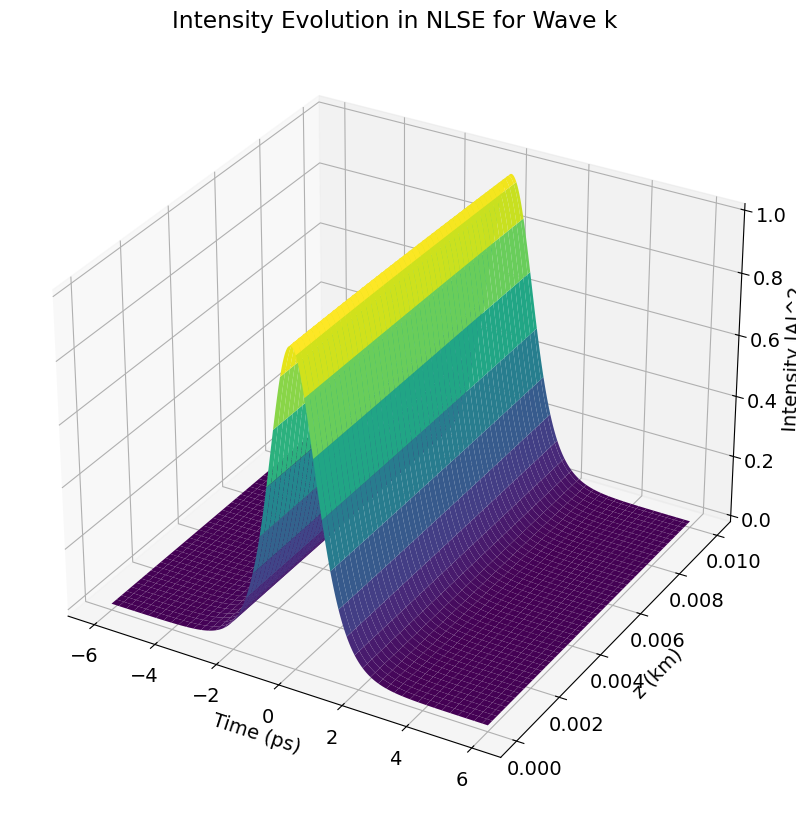

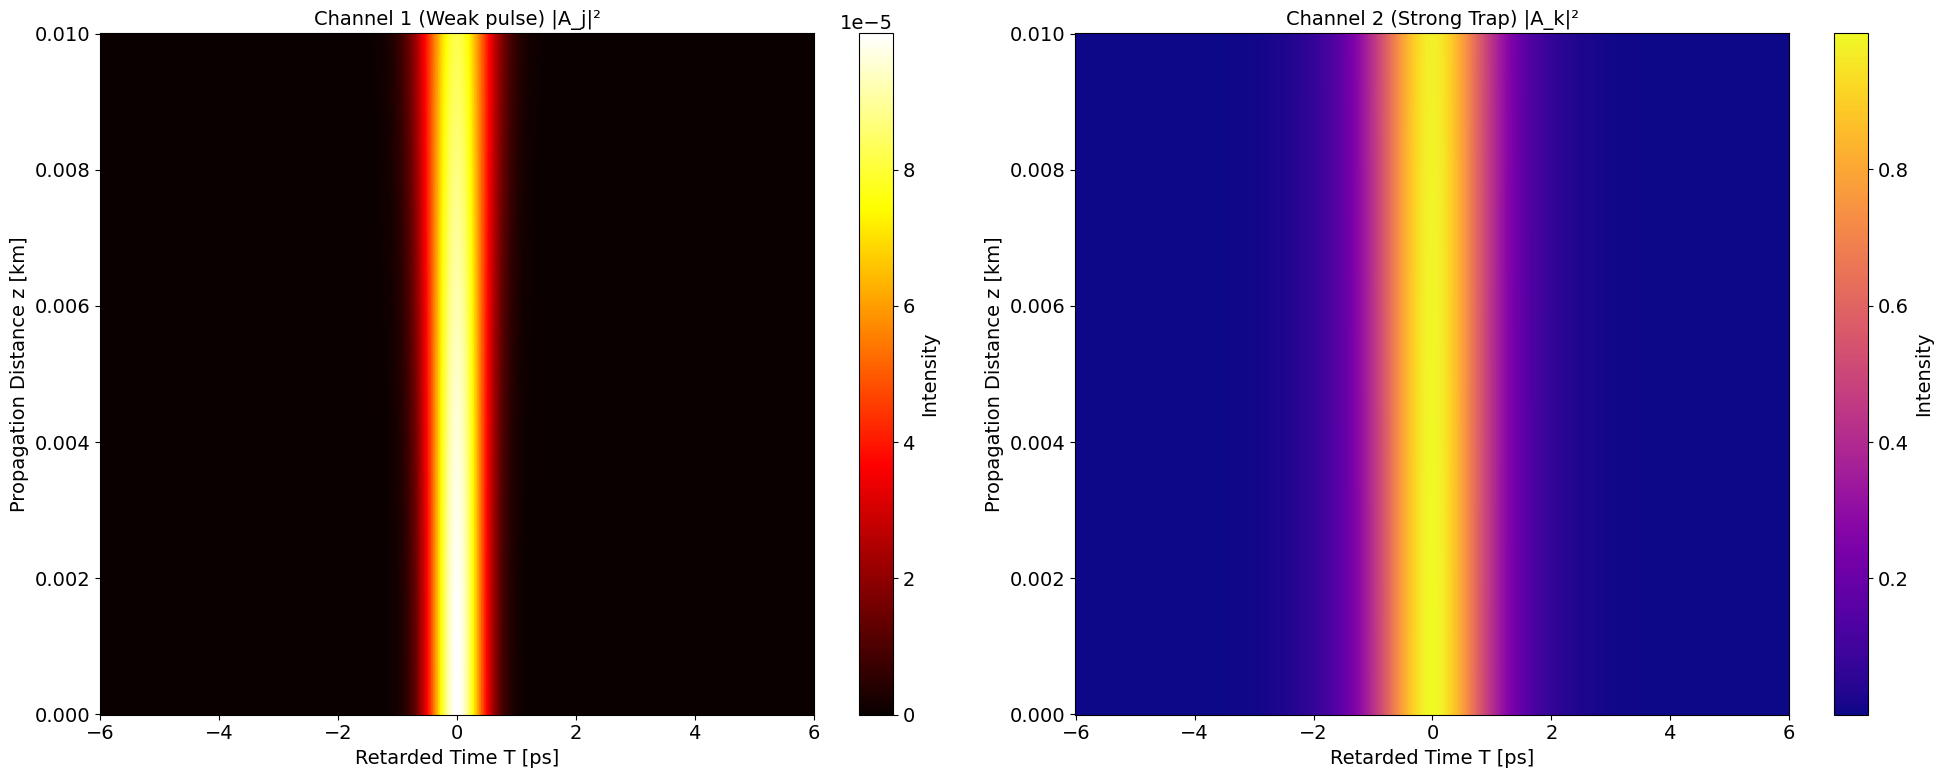

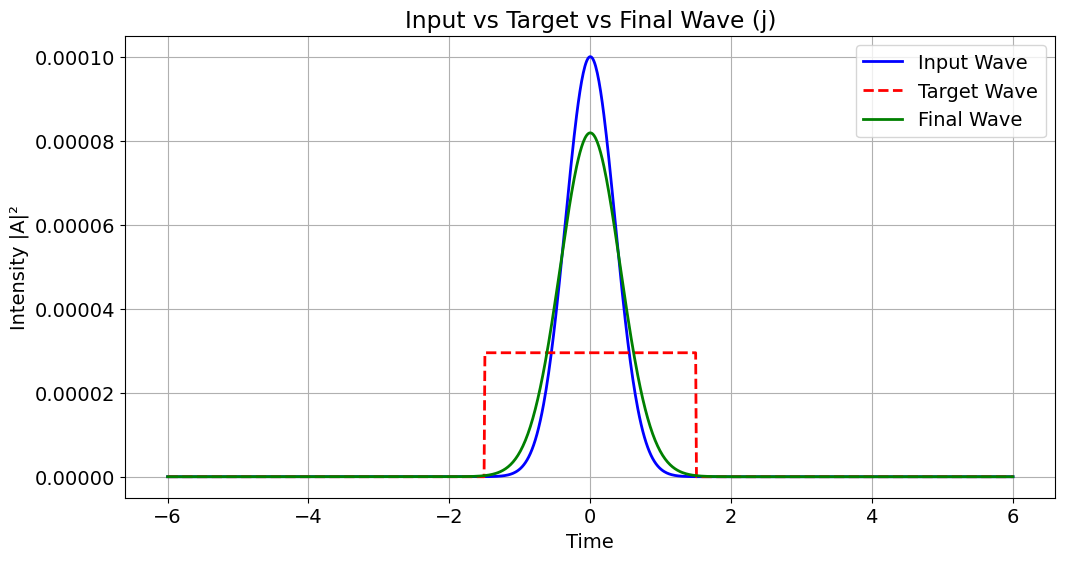

In [70]:
# plot the loss
plt.plot(losses, color='m', marker="o")
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid()
plt.show()

# plot the evolution of the waves
plot_intensity_evolution(A_j_evolution, t, Lz, Nz, wave_name='Wave j')
plot_intensity_evolution(A_k_evolution, t, Lz, Nz, wave_name='Wave k')
plot_cowave_evolution(A_j_evolution.detach().clone(), A_k_evolution.detach().clone(), t, Lz, Nz)

# plot the target vs the final wave
plt.figure(figsize=(12, 6))
plt.plot(t, np.abs(Ain_j.detach().cpu().numpy())**2, 'b-', label='Input Wave', linewidth=2)
plt.plot(t, np.abs(A_target.detach().cpu().numpy())**2, 'r--', label='Target Wave', linewidth=2)
plt.plot(t, np.abs(A_j_evolution[:, -1].detach().cpu().numpy())**2, 'g-', label='Final Wave', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Intensity |A|²')
plt.title('Input vs Target vs Final Wave (j)')
plt.legend()
plt.grid()
plt.show()
